Fischer Wahlfachprojekt 2

Vergleich von Machine Learning frameworks 
* Tensorflow
* Prophet
* Pytorch

# General
1. import statements
2. data cleanup/split
Per framework:
1. Training
2. Ergebnisse

In [1]:
import os
import copy
import math

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from prophet import Prophet
from tqdm.notebook import tqdm
from datetime import datetime
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

pd.options.mode.copy_on_write = True

# stores error of each framework encoded as root mean square error (RMSE)
performance = {}

2024-12-31 15:32:46.894706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-31 15:32:46.912888: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-31 15:32:46.918440: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-31 15:32:46.931716: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-31 15:32:47.827199: W tensorflow/compiler/tf2

In [2]:
# download data
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
csv_name = "/jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path + csv_name)

# data cleanup
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# normalize wind direction
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')
# convert degrees to radians because the absolute distance between them is smaller
wd_rad = df.pop('wd (deg)') * np.pi / 180
# calculate the wind x and y components
df['Wx'] = wv * np.cos(wd_rad)
df['Wy'] = wv * np.sin(wd_rad)
# calculate the max wind x and y components
df['max Wx'] = max_wv * np.cos(wd_rad)
df['max Wy'] = max_wv * np.sin(wd_rad)

# statistics of the dataset
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),420551.0,989.212776,8.358481,913.600000,984.200000,989.580000,994.720000,1015.350000
T (degC),420551.0,9.450147,8.423365,-23.010000,3.360000,9.420000,15.470000,37.280000
Tpot (K),420551.0,283.492743,8.504471,250.600000,277.430000,283.470000,289.530000,311.340000
Tdew (degC),420551.0,4.955854,6.730674,-25.010000,0.240000,5.220000,10.070000,23.110000
rh (%),420551.0,76.008259,16.476175,12.950000,65.210000,79.300000,89.400000,100.000000
VPmax (mbar),420551.0,13.576251,7.739020,0.950000,7.780000,11.820000,17.600000,63.770000
VPact (mbar),420551.0,9.533756,4.184164,0.790000,6.210000,8.860000,12.350000,28.320000
VPdef (mbar),420551.0,4.042412,4.896851,0.000000,0.870000,2.190000,5.300000,46.010000
sh (g/kg),420551.0,6.022408,2.656139,0.500000,3.920000,5.590000,7.800000,18.130000
H2OC (mmol/mol),420551.0,9.640223,4.235395,0.800000,6.290000,8.960000,12.490000,28.820000


# TensorFlow

In [14]:
data_tf_start = datetime.now()
tensorflow_df = copy.deepcopy(df)

# parse timestamps to convert them into a more suitable linear representation 
date_time = pd.to_datetime(
    tensorflow_df['Date Time'], 
    format='%d.%m.%Y %H:%M:%S'
)
timestamp_s = date_time.map(pd.Timestamp.timestamp)

DAY = 24 * 60 * 60
YEAR = (365.2425) * DAY

tensorflow_df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / DAY))
tensorflow_df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / DAY))
tensorflow_df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / YEAR))
tensorflow_df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / YEAR))


train_df = tensorflow_df[
    ~(
        (tensorflow_df["Date Time"].str.contains("2014")) | 
        (tensorflow_df["Date Time"].str.contains("2010"))
    )
]
val_df = tensorflow_df[
    (tensorflow_df["Date Time"].str.contains("2014"))
]
test_df = tensorflow_df[
    (tensorflow_df["Date Time"].str.contains("2010"))
]

# discard raw timestamp
tensorflow_df.pop("Date Time")
train_df.pop("Date Time")
val_df.pop("Date Time")
test_df.pop("Date Time")

num_features = tensorflow_df.shape[1]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
data_tf_end = datetime.now()

0:00:03.003270
0:03:25.329740


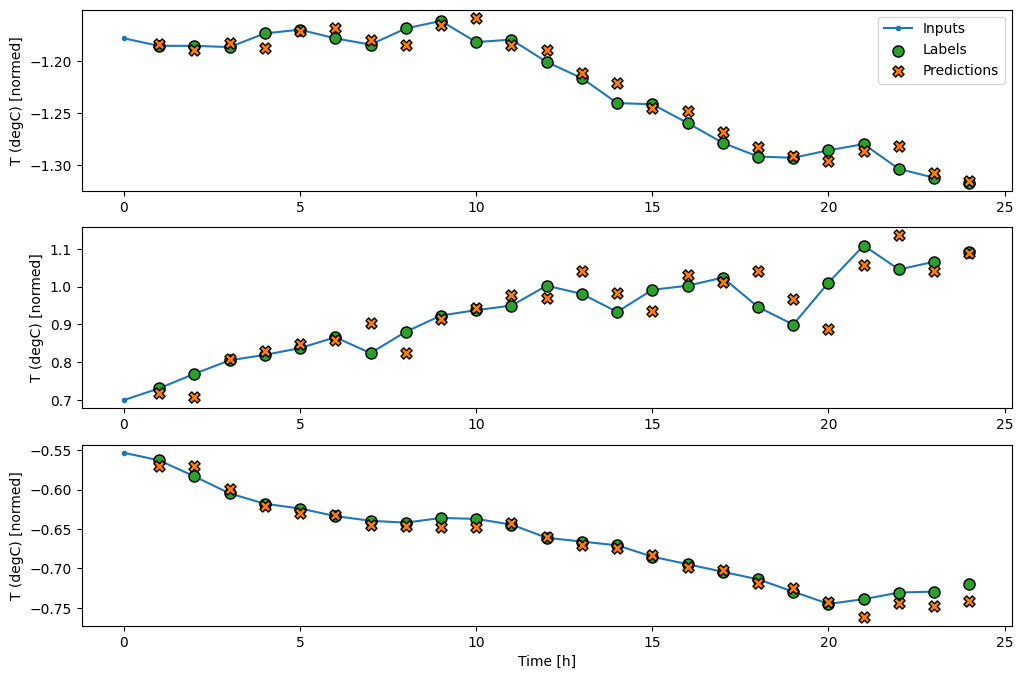

In [15]:
train_tf_start = datetime.now()
# window generating for training
# https://www.tensorflow.org/tutorials/structured_data/time_series#1_indexes_and_offsets
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # store the raw data
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # work out the label column indices
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # work out the window parameters
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    return inputs, labels

  def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)
      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32
    )
    ds = ds.map(self.split_window)
    return ds
      
  @property
  def train(self):
    return self.make_dataset(self.train_df)
  
  @property
  def val(self):
    return self.make_dataset(self.val_df)
  
  @property
  def test(self):
    return self.make_dataset(self.test_df)
      
  @property
  def example(self):
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result


# sets needed parameters
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH
window = WindowGenerator(
    input_width=INPUT_WIDTH, 
    label_width=LABEL_WIDTH, 
    shift=1
)

MAX_EPOCHS = 10

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # the prediction for each time step is the input from the 
    # previous time step plus the delta calculated by the model
    return inputs + delta

#model
model = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # the predicted deltas should start small, therefore, initialize the
        # output layer with zeros
        kernel_initializer=tf.initializers.zeros())
]))

# computes the model
history = compile_and_fit(model, window)

performance['tensorflow'] = model.evaluate(window.test, verbose=0, return_dict=True)

# plots prediction
IPython.display.clear_output()
window.plot(model)
train_tf_end = datetime.now()

print(data_tf_end - data_tf_start)
print(train_tf_end - train_tf_start)

# Prophet

In [3]:
data_pro_start = datetime.now()
prophet_df = copy.deepcopy(df)

# parse timestamp
TIMESTAMP_FORMAT = "%d.%m.%Y %H:%M:%S"

def reformat_date(timestamp):
    return datetime.strptime(timestamp, TIMESTAMP_FORMAT).strftime('%Y-%m-%d %H:%M:%S')

prophet_df["Date Time"] = prophet_df["Date Time"].map(reformat_date)

# prophet expects a "ds" and "y" column in each data frame
# "ds" contains the dates for which a prediction is to be made, and "y" is the label
prophet_df = prophet_df.rename(columns={"Date Time": "ds"})
prophet_df = prophet_df.rename(columns={"T (degC)": "y"})

# split in training, validation and test data frames
train_df = prophet_df[~((prophet_df["ds"].str.contains("2014")) | (prophet_df["ds"].str.contains("2010")))]
val_df = prophet_df[(prophet_df["ds"].str.contains("2014"))]
test_df = prophet_df[(prophet_df["ds"].str.contains("2010"))]

train_df.head()
data_pro_end = datetime.now()

In [4]:
train_pro_start = datetime.now()
model_Prophet = Prophet()
model_Prophet.add_regressor('p (mbar)')
model_Prophet.add_regressor('Tpot (K)')
model_Prophet.add_regressor('Tdew (degC)')
model_Prophet.add_regressor('rh (%)')
model_Prophet.add_regressor('VPmax (mbar)')
model_Prophet.add_regressor('VPact (mbar)')
model_Prophet.add_regressor('VPdef (mbar)')
model_Prophet.add_regressor('sh (g/kg)')
model_Prophet.add_regressor('H2OC (mmol/mol)')
model_Prophet.add_regressor('rho (g/m**3)')
model_Prophet.add_regressor('Wx')
model_Prophet.add_regressor('Wy')
model_Prophet.add_regressor('max Wx')
model_Prophet.add_regressor('max Wy')
model_Prophet.fit(train_df)
train_pro_end = datetime.now()

15:33:43 - cmdstanpy - INFO - Chain [1] start processing
15:50:35 - cmdstanpy - INFO - Chain [1] done processing


In [5]:
observed_temp =  test_df.pop('y') # only needed once otherwise an error is thrown
test_df.head()

,ds,p (mbar),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy
52557,2010-01-01 00:00:00,967.36,272.89,-3.43,95.7,4.95,4.74,0.21,3.05,4.90,1244.34,2.680922,1.254695,4.175355,1.954102
52558,2010-01-01 00:10:00,967.56,272.89,-3.41,95.8,4.95,4.75,0.21,3.06,4.91,1244.56,1.552119,0.427816,2.660775,0.733399
52559,2010-01-01 00:20:00,967.45,272.88,-3.43,95.7,4.95,4.74,0.21,3.05,4.90,1244.48,1.912201,0.586079,2.963911,0.908422
52560,2010-01-01 00:30:00,967.45,272.85,-3.46,95.8,4.94,4.73,0.21,3.05,4.89,1244.65,2.033346,0.963330,3.425058,1.622676
52561,2010-01-01 00:40:00,967.34,272.84,-3.47,95.8,4.93,4.72,0.21,3.04,4.88,1244.57,2.418459,1.058610,3.453633,1.511727


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,H2OC (mmol/mol),H2OC (mmol/mol)_lower,H2OC (mmol/mol)_upper,Tdew (degC),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-01-01 00:00:00,9.571684,-2.859077,-2.831836,9.571684,9.571684,0.553808,0.553808,0.553808,0.047259,...,-0.000169,-0.000169,-0.000169,-0.005126,-0.005126,-0.005126,0.0,0.0,0.0,-2.845828
1,2010-01-01 00:10:00,9.571684,-2.848351,-2.820765,9.571684,9.571684,0.552636,0.552636,0.552636,0.047147,...,-0.000175,-0.000175,-0.000175,-0.005124,-0.005124,-0.005124,0.0,0.0,0.0,-2.833627
2,2010-01-01 00:20:00,9.571684,-2.862879,-2.834954,9.571684,9.571684,0.553808,0.553808,0.553808,0.047259,...,-0.000181,-0.000181,-0.000181,-0.005122,-0.005122,-0.005122,0.0,0.0,0.0,-2.849051
3,2010-01-01 00:30:00,9.571684,-2.895996,-2.868468,9.571684,9.571684,0.554979,0.554979,0.554979,0.047428,...,-0.000187,-0.000187,-0.000187,-0.005121,-0.005121,-0.005121,0.0,0.0,0.0,-2.881811
4,2010-01-01 00:40:00,9.571684,-2.911986,-2.885138,9.571684,9.571684,0.556151,0.556151,0.556151,0.047484,...,-0.000193,-0.000193,-0.000193,-0.005119,-0.005119,-0.005119,0.0,0.0,0.0,-2.898514


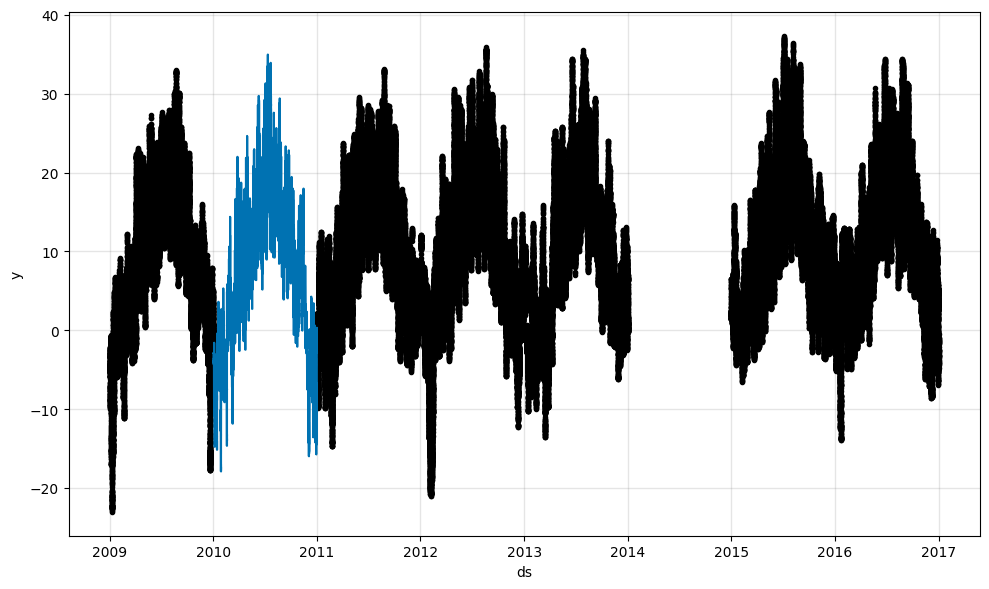

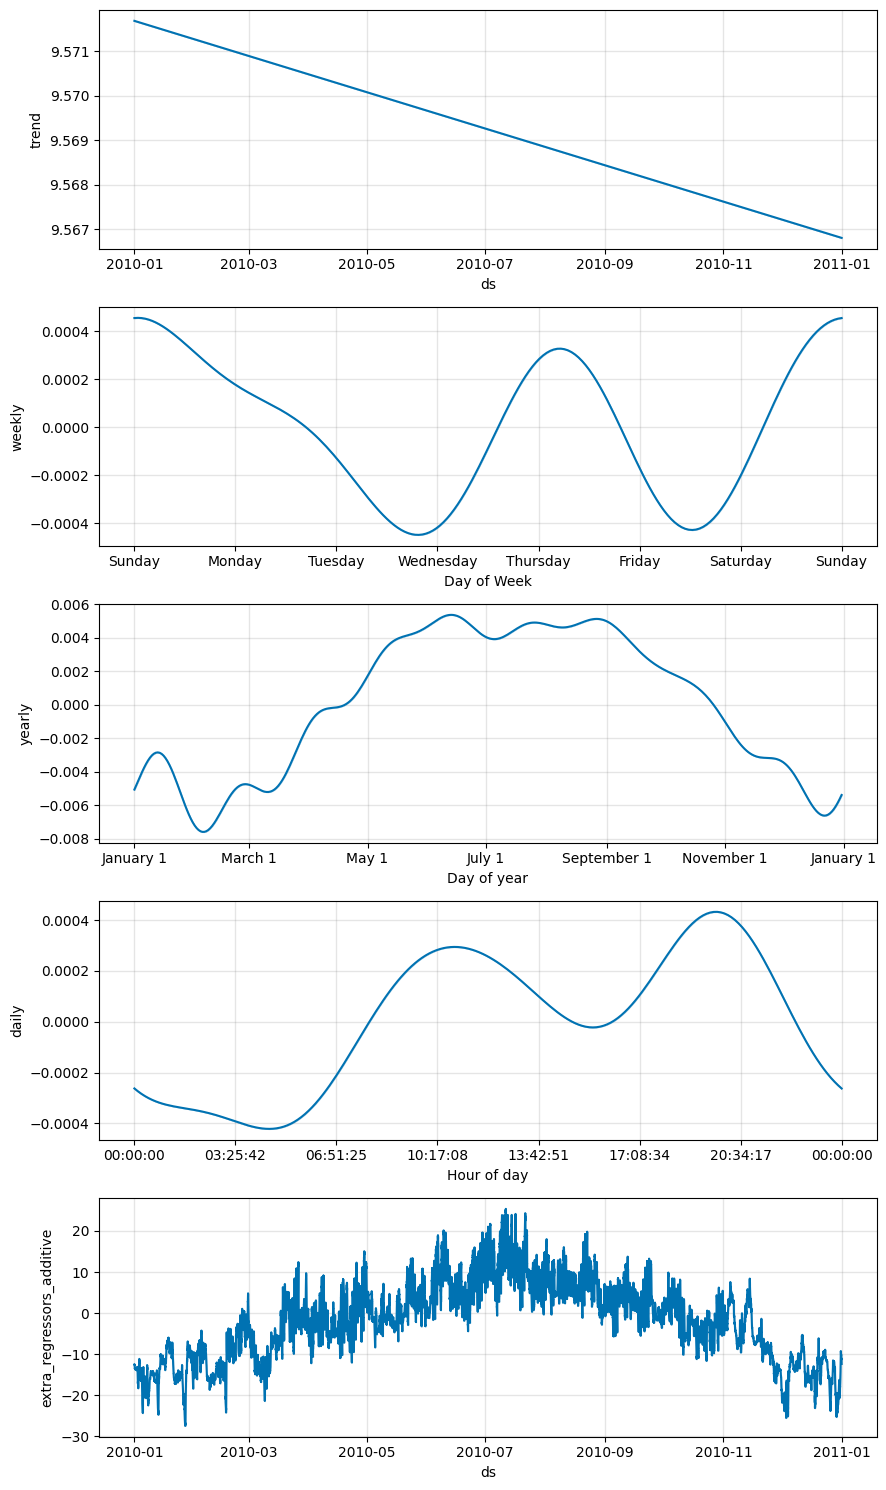

In [6]:
# prediction
forecast = model_Prophet.predict(test_df)
fig1 = model_Prophet.plot(forecast)
fig2 = model_Prophet.plot_components(forecast)
forecast.head()

In [7]:
# calculating the RMSE of the prediction on the test set
sum_difference = 0
# offset to first data frame in test year
count = 52557

for i in forecast.itertuples():
    predicted = i.yhat
    sum_difference += (predicted - observed_temp.loc[count]) ** 2
    count += 1
    
performance['prophet'] = math.sqrt(sum_difference / forecast.shape[0])

print(data_pro_end - data_pro_start)
print(train_pro_end - train_pro_start)

0:00:04.368540
0:17:22.317834


# Pytorch

In [8]:
data_torch_start = datetime.now()
LABEL_WIDTH = 24
MAX_EPOCHS = 10

pytorch_df = copy.deepcopy(df)

# split in train, val and test dataframe
train_df = pytorch_df[
    ~((pytorch_df["Date Time"].str.contains("2014")) | (pytorch_df["Date Time"].str.contains("2010")))]
val_df = pytorch_df[(pytorch_df["Date Time"].str.contains("2014"))]
test_df = pytorch_df[(pytorch_df["Date Time"].str.contains("2010"))]

# parse timestamps to convert them into a more suitable linear representation 
date_time = pd.to_datetime(
    pytorch_df['Date Time'], 
    format='%d.%m.%Y %H:%M:%S'
)
timestamp_s = date_time.map(pd.Timestamp.timestamp)

DAY = 24 * 60 * 60
YEAR = (365.2425) * DAY

pytorch_df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / DAY))
pytorch_df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / DAY))
pytorch_df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / YEAR))
pytorch_df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / YEAR))

pytorch_df.pop("Date Time")
train_df.pop("Date Time")
val_df.pop("Date Time")
test_df.pop("Date Time")

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

train_label = train_df['T (degC)'].values
val_label = val_df['T (degC)'].values
test_label = test_df['T (degC)'].values

In [9]:
class WeatherDataset(Dataset):
    def __init__(self, data, labels, label_width):
        self.data = data
        self.labels = labels
        self.label_width = label_width

    def __len__(self):
        return len(self.data) - self.label_width

    def __getitem__(self, idx):
        X = self.data.iloc[idx:idx+self.label_width, :].values
        y = self.labels[idx + self.label_width]
        
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Create training and test datasets
train_dataset = WeatherDataset(train_df, train_label, LABEL_WIDTH)
test_dataset = WeatherDataset(test_df, test_label, LABEL_WIDTH)

BATCH_SIZE = 32
DIMENSIONS = train_df.shape[1]

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)  # Use an appropriate batch size
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

data_torch_end = datetime.now()
train_torch_start = datetime.now()

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=layer_dim,
            batch_first=True
        )
        #batch_first to have (batch_dim, seq_dim, feature_dim)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])
        return out


def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

device = get_device()

model = LSTM(DIMENSIONS, 32, 1, 1)
model.to(device)

def train(model,
          learning_rate,
          train_loader, 
          test_loader,
          epochs=MAX_EPOCHS):
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            # pivot 
            targets = targets.unsqueeze(1)
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            
            loss = criterion(outputs, targets)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()


        # Train loss
        train_losses[epoch] = running_loss / len(train_loader)

        # Test loss
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                targets = targets.unsqueeze(1)
                inputs, targets = inputs.to(device), targets.to(device)
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()

        test_losses[epoch] = test_loss / len(test_loader)
        print(f'At epoch {epoch+1}/{epochs}, Train Loss: {train_losses[epoch]:.3f}, Test Loss: {test_losses[epoch]:.3f}')

    return train_losses, test_losses


# Training the model with the DataLoader
train_losses, test_losses = train(model,
                                   0.01,
                                   train_loader,
                                   test_loader,
                                   epochs=MAX_EPOCHS)
train_torch_end = datetime.now()

At epoch 1/10, Train Loss: 0.013, Test Loss: 0.013
At epoch 2/10, Train Loss: 0.004, Test Loss: 0.005
At epoch 3/10, Train Loss: 0.004, Test Loss: 0.006
At epoch 4/10, Train Loss: 0.004, Test Loss: 0.008
At epoch 5/10, Train Loss: 0.003, Test Loss: 0.008
At epoch 6/10, Train Loss: 0.003, Test Loss: 0.002
At epoch 7/10, Train Loss: 0.003, Test Loss: 0.007
At epoch 8/10, Train Loss: 0.002, Test Loss: 0.006
At epoch 9/10, Train Loss: 0.005, Test Loss: 0.024
At epoch 10/10, Train Loss: 0.003, Test Loss: 0.006


In [10]:
#calculation RMSE
sum_difference = 0

for inputs, labels in test_dataset:
    target = labels.item()

    unsqueezed = inputs.unsqueeze(0)
    predicted = model(unsqueezed.to(device))

    sum_difference += (predicted - target) ** 2

performance['pytorch'] = math.sqrt(sum_difference / len(test_loader.dataset))

print(data_torch_end - data_torch_start)
print(train_torch_end - train_torch_start)

0:00:02.628533
0:07:13.643781


# RESULTS

In [16]:
for key in performance:
    print(key, "has RSME of: ", performance[key])

prophet has RSME of:  0.4770023931054926
pytorch has RSME of:  0.07877506171423536
tensorflow has RSME of:  {'loss': 0.006980661302804947, 'root_mean_squared_error': 0.0835503488779068}
